In [ ]:
#deep convolutional network(dcgan) will be made to generate hand written digits

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

configurations

In [7]:
device = 'cuda'   #since we are connected to gpu and we will use pytorch in gpu so we have to transfer the tensors or images to the gpu
#device to be used to tranfer image to the gpu device

batch_size =128#trainloader ,training loop
noise_dim =64 #shape of the random noise vector and will be used to create generator model
#optimizers paramteters

lr =0.0002 #learning rate
beta_1=0.5 # goin to be useful in addum optimizer
beta_2 =0.99

#Training variables, the no. of times we want to run our training loop
epochs= 20

load MNIST Dataset



In [4]:
from torchvision import datasets, transforms as T

In [5]:
#augmentation
train_augs = T.Compose([
                         T.RandomRotation((-20,+20)),
                         T.ToTensor()# to convert the numpy or pil images to torch tensor and shift channel to zeroth axis
])

In [ ]:
#pytorch uses (c,h,w) convention so we used T.ToTensor() to change the(h,w,c) to the (c,h,w),ie, c to zeroth axis 
#h--height
#c--channel
#w--width

In [6]:
trainset = datasets.MNIST('MNIST/',download=True, train = True, transform=train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



load dataset into batches

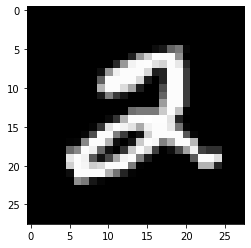

In [8]:
image, label =trainset[5] #show the image in index 5 of training set
plt.imshow(image.squeeze(),cmap ='gray')

In [ ]:
# to print the total images present

In [9]:
print("total images present in the trainset are:", len(trainset))

total images present in the trainset are: 60000


load dataset into batches

In [ ]:
# group dataset into batches each of size 128

In [10]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [11]:
trainloader = DataLoader(trainset, batch_size= 128,shuffle =True)

In [12]:
print("total no. of batches in trainloader:", len(trainloader))

total no. of batches in trainloader: 469


In [13]:
dataiter = iter(trainloader) 
images,_ = dataiter.next() #_ is used there is no label
print(images.shape)

torch.Size([128, 1, 28, 28])


In [14]:
def show_tensor_images(tensor_img, num_images =16, size=(1,28,28)):
  unflat_img =tensor_img.detach().cpu()
  img_grid =make_grid(unflat_img[:num_images],nrow=4)
  plt.imshow(img_grid.permute(1,2,0).squeeze())
  plt.show()

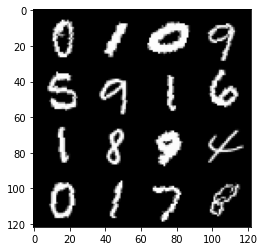

In [15]:
show_tensor_images(images,num_images =16)

create discriminator network

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [16]:
from torch import nn
from torchsummary import summary

In [17]:
def get_disc_block(in_channels, out_channels,kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels,kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)#Activation Function LeakyReLU with lower limit 0.2
  )

In [18]:
class Discriminator(nn.Module): # creating the disc network
  def __init__(self):#initialize layers which we want to use in the discriminator
    super(Discriminator,self).__init__()

    self.block_1= get_disc_block(1,16,(3,3),2)
    self.block_2= get_disc_block(16,32,(5,5),2)
    self.block_3= get_disc_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features =64, out_features=1)
  def forward(self,images):

    x1= self.block_1(images)
    x2= self.block_2(x1)
    x3= self.block_3(x2)

    x4= self.flatten(x3)
    x5= self.linear(x4)

    return x5
# we are not using sigmoid layer over here because we are going to use binary cross entropy with logit loss which takes raw outputs

In [19]:
#Summary of the model

D= Discriminator()
D.to(device) # to move network to gpu device

summary(D, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

create generator network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''                       

In [29]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()#activation function
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )


In [30]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)

    self.block_4 = get_gen_block(64,1,(4,4),2, final_block =True)

  def forward(self, r_noise_vec):

    # (bs, noise_dim) -> (bs, noise_dim, 1 ,1)
    x = r_noise_vec.view(-1, self.noise_dim,1,1)
    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4


In [31]:
#Summary of the model

G = Generator(noise_dim)
G.to(device) # to move network to gpu device

summary(G, input_size = (1,noise_dim ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [34]:
#replace random initialized weights to normal weights

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
    nn.init.constant_(m.bias, 0)

In [35]:
D= D.apply(weights_init)
G= G.apply(weights_init)

In [36]:
def real_loss(disc_pred):#Loss of discriminator/Generator prediction and 1 
  criterion= nn.BCEWithLogitsLoss() #For Loss Function
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):#Loss of discriminator/Generator prediction and 0
  criterion= nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss= criterion(disc_pred, ground_truth)
  return loss

In [37]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas= (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas= (beta_1, beta_2))

TRAINING GAN

In [39]:
from tqdm import tqdm # for creating a progress bar to track the progress of the loops

100%|██████████| 469/469 [00:17<00:00, 27.43it/s]


Epoch : 1 | D_loss :0.6846226197061762 | G_loss : 0.6825507909758513


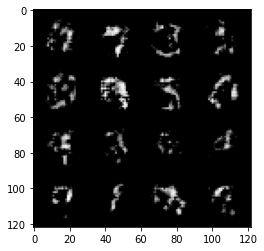

100%|██████████| 469/469 [00:16<00:00, 28.99it/s]


Epoch : 2 | D_loss :0.6796198850755752 | G_loss : 0.7091079177632769


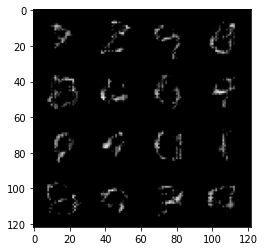

100%|██████████| 469/469 [00:16<00:00, 29.11it/s]


Epoch : 3 | D_loss :0.6399785285311212 | G_loss : 0.7509606124749825


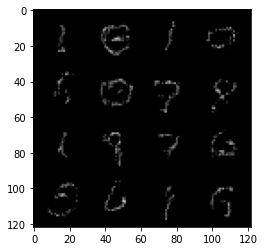

100%|██████████| 469/469 [00:17<00:00, 27.33it/s]


Epoch : 4 | D_loss :0.5978153075999034 | G_loss : 0.8054870153540996


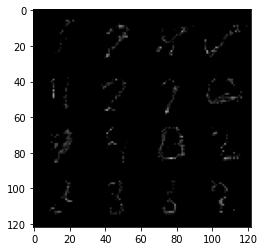

100%|██████████| 469/469 [00:17<00:00, 27.51it/s]


Epoch : 5 | D_loss :0.5789088941077942 | G_loss : 0.8443419102158374


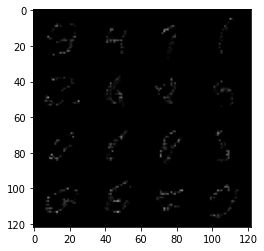

100%|██████████| 469/469 [00:16<00:00, 28.10it/s]


Epoch : 6 | D_loss :0.5992995384913772 | G_loss : 0.8352768933976383


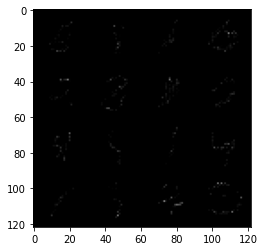

100%|██████████| 469/469 [00:16<00:00, 28.37it/s]


Epoch : 7 | D_loss :0.6193853229093653 | G_loss : 0.8205623786840865


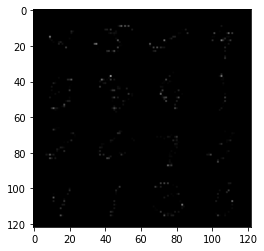

100%|██████████| 469/469 [00:16<00:00, 28.67it/s]


Epoch : 8 | D_loss :0.6316777805783855 | G_loss : 0.8084438727862799


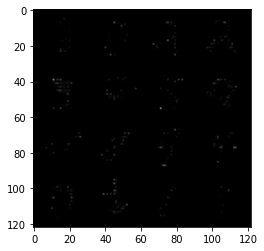

100%|██████████| 469/469 [00:16<00:00, 28.62it/s]


Epoch : 9 | D_loss :0.6395226026903084 | G_loss : 0.797360415778943


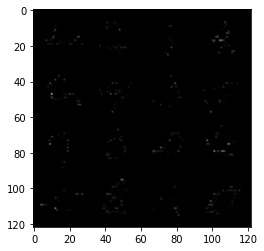

100%|██████████| 469/469 [00:16<00:00, 28.62it/s]


Epoch : 10 | D_loss :0.646484809897856 | G_loss : 0.7900829634178422


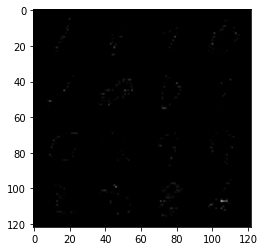

100%|██████████| 469/469 [00:16<00:00, 28.94it/s]


Epoch : 11 | D_loss :0.6520494586114944 | G_loss : 0.782984693294395


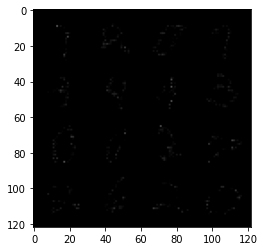

100%|██████████| 469/469 [00:16<00:00, 28.39it/s]


Epoch : 12 | D_loss :0.6539101784925725 | G_loss : 0.7806472027225535


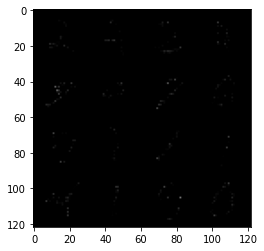

100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


Epoch : 13 | D_loss :0.6562401559561301 | G_loss : 0.7809903903810709


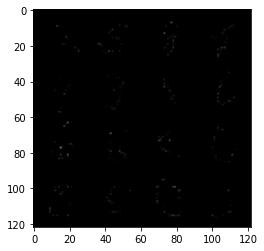

100%|██████████| 469/469 [00:16<00:00, 29.03it/s]


Epoch : 14 | D_loss :0.6579862995696729 | G_loss : 0.7777027046756704


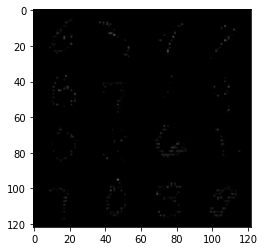

100%|██████████| 469/469 [00:16<00:00, 28.87it/s]


Epoch : 15 | D_loss :0.6584316647129018 | G_loss : 0.7771920934160635


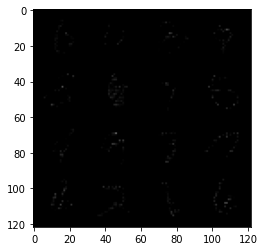

100%|██████████| 469/469 [00:16<00:00, 29.10it/s]


Epoch : 16 | D_loss :0.6584429613816967 | G_loss : 0.7781690307009195


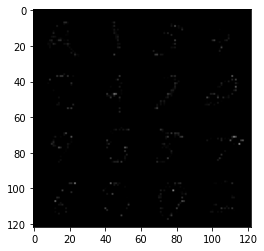

100%|██████████| 469/469 [00:16<00:00, 27.66it/s]


Epoch : 17 | D_loss :0.6565766345971683 | G_loss : 0.7799397876013571


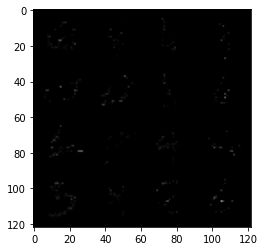

100%|██████████| 469/469 [00:16<00:00, 28.79it/s]


Epoch : 18 | D_loss :0.6555006652752727 | G_loss : 0.780453883762807


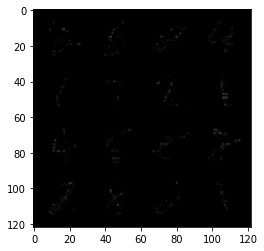

100%|██████████| 469/469 [00:16<00:00, 28.71it/s]


Epoch : 19 | D_loss :0.656078827914907 | G_loss : 0.7804482279301707


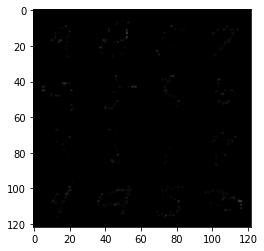

100%|██████████| 469/469 [00:16<00:00, 28.49it/s]


Epoch : 20 | D_loss :0.6549941389037094 | G_loss : 0.783705664977336


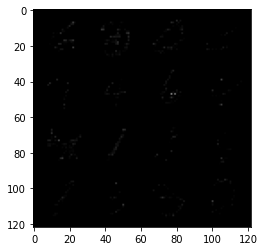

In [41]:
for i in range (epochs):

  total_d_loss =0.0
  total_g_loss =0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    #find loss and update weights for D and training it 
    D_opt.zero_grad() # optimizing the disc with 0 gradient

    fake_img = G(noise)# generating fake images by passing the noise from torch to generator
    D_pred =D(fake_img)# the prediction from disc for a fake image generated from generator
    D_fake_loss = fake_loss(D_pred)

    D_pred =D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    #find loss and update weights for G
    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_img =G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch : {} | D_loss :{} | G_loss : {}". format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)